In [1]:
import numpy as np

import jax
import jax.numpy as jnp
from jax import grad, jit

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import torch

from tqdm import tqdm
import matplotlib.pyplot as plt

# Hogg's Idea

We want to learn $h^{-1}$ such that
$$
h^{-1}(\theta) \star g_{naive}^{-1}(\vec r) \star \vec N_i(g(\theta, \vec r) \cdot I(\vec r)) = \vec N_i(I(\vec r))
$$
where $\vec N_i \in \mathbb R^c \times \mathbb R^{l \times l}$, it's a vector over channels, containing images of size $l$. Note, Hogg believes $\partial_{\vec r} h^{-1} = 0$, $h^{-1}$, can be expressed independent of coordinates.

Hogg's proposition is the learned $h^{-1} $ is a real-valued matrix which acts on the level of the channels
$$
h^{-1} = \begin{pmatrix}
h_{11}^{-1} & h_{21}^{-1} & ...\\
h_{21}^{-1} & h_{22}^{-1} & ...\\
\vdots & \vdots & \ddots
\end{pmatrix} \in \mathbb M^{c \times c}(\mathbb R)
$$

## Methodology
Solve
$$
Ax = y
$$
such that $x := g_{naive}^{-1}(\vec r) \star \vec N_i(g(\theta, \vec r) \cdot I(\vec r))$ and $y := \vec N_i(I(\vec r))$. So the matrix multiplication is occurring on the level of the channels.

## Download Data
Get layers 14-19. All same resolution

In [6]:
target_pic = '0000'
numbers = [f"{i:02}" for i in range(14,19+1)]

### Load: $N(g * i)$

In [7]:
data_dir = '/vast/xj2173/diffeo/data/all_cnn_layers/'
data_name = [data_dir + f'15-100-4-4-3-224-224_image-{target_pic}_activation_layer-{i}.pt' for i in numbers]


# data[0] is the 0th picture, data[1] is the 1st picture, etc..
data = [torch.load(file_name, map_location='cpu') for file_name in tqdm(data_name)]
data = torch.stack(data, dim=0)
data.shape

100%|██████████| 6/6 [00:01<00:00,  3.45it/s]


torch.Size([6, 1500, 128, 14, 14])

In [8]:
res_of_layer = data.shape[-1]
res_of_layer

14

### Load: $g^{-1}_{naive}$ and Apply to $g^{-1}_{naive} \star N(g * I)$
- 15 stregnths
- 100 different diffeos
- For a 244 x 244 sized image
- In 2 directions, x and y push

In [9]:
data_dir = '/vast/xj2173/diffeo/data/all_cnn_layers/'
file_name = data_dir + '15-100-4-4-3-224-224_inv_grid_sample.pt'
inv_diffeos_maps = torch.load(file_name, map_location='cpu')
inv_diffeos_maps = torch.stack(inv_diffeos_maps)
print(inv_diffeos_maps.shape)

torch.Size([15, 100, 224, 224, 2])


In [10]:
# Downsample transformation to resolution of convolutional layer

inv_diffeos_maps = inv_diffeos_maps.reshape(15 * 100, 224, 224, 2)
inv_diffeos_maps = inv_diffeos_maps.permute(0, 3, 1, 2)
inv_diffeos_maps = torch.nn.functional.interpolate(inv_diffeos_maps, size=(res_of_layer, res_of_layer), mode='bilinear', align_corners=False)
inv_diffeos_maps = inv_diffeos_maps.permute(0, 2, 3, 1)

inv_diffeos_maps.shape

torch.Size([1500, 14, 14, 2])

In [11]:
mode = 'bilinear'
data_inv = [torch.nn.functional.grid_sample(pic_data, inv_diffeos_maps, mode = mode) for pic_data in tqdm(data)]
data_inv = torch.stack(data_inv, dim=0)

data_inv.shape

  0%|          | 0/6 [00:00<?, ?it/s]/vast/cm6627/condaenv_diffeo_cnn/lib/python3.10/site-packages/torch/nn/functional.py:4343: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
100%|██████████| 6/6 [00:00<00:00, 14.56it/s]


torch.Size([6, 1500, 128, 14, 14])

### Load: $N_i(I)$


In [15]:
data_dir = '/vast/xj2173/diffeo/data/reference/'
data_name = [data_dir + f'val_image-{target_pic}_activation_layer-{i}.pt' for i in numbers]

# ref_data[0] is the 0th picture, ref_data[1] is the 1st picture, etc..
ref_data = [torch.load(file_name, map_location='cpu').squeeze(0) for file_name in tqdm(data_name)]
ref_data = torch.stack(ref_data)
ref_data.shape


100%|██████████| 6/6 [00:00<00:00, 96.74it/s]


torch.Size([6, 128, 14, 14])

## Attempt 1: Matrix Inverse, Independent of Position

In this case, entries of $h^{-1}$ have the same value at every pixel position

Our loss function $\mathcal L$ is:
$$
\forall i,j; \ \  \  \min_{[h^{-1}]_{ij}} \mathcal L = \min_{[h^{-1}]_{ij}} \text{RMSE} \left ( h^{-1} g_{naive}^{-1} N_i(g \cdot I)  ,  N_i(I)\right) 
$$

In [130]:
layer_idx = 5 #0 := layer 14, 5 := layer 19
diffeo_idx = 0

feature = data[layer_idx, diffeo_idx, :, :, :]
label = ref_data[layer_idx, :, :, :]
feature.shape, label.shape

(torch.Size([128, 14, 14]), torch.Size([128, 14, 14]))

In [131]:
import torch
import torch.optim as optim

# Define the loss function
def loss(A, features, labels):
    predictions = torch.einsum('ab,axy->bxy', A, features)
    return torch.mean((predictions - labels) ** 2)


# Initialize A with normal distribution
features_shape = (len(feature), len(feature))  # Replace with the actual shape of your features
A = torch.randn(features_shape, requires_grad=True)

# Hyperparameters
learning_rate = 0.0001
num_iterations = 100000
threshold = 1e-6  # Define a threshold for change in loss
patience = 100  # Define the number of iterations to wait before stopping if no improvement
counter = 0  # Initialize a counter to track the number of iterations without significant change
previous_loss = float('inf')  # Initialize the previous loss to a high value


# Define the optimizer
optimizer = optim.Adam([A], lr=learning_rate)

for i in range(num_iterations):
    optimizer.zero_grad()  # Zero the gradients before each iteration
    current_loss = loss(A, feature, label)
    current_loss.backward()  # Backpropagate to compute gradients
    optimizer.step()  # Update parameters
    
    if i % 500 == 0:
        print(f"Iteration {i}: Loss = {current_loss.item()}")
    
    # Check for early stopping
    if abs(previous_loss - current_loss.item()) < threshold:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at iteration {i}: Loss = {current_loss.item()}")
            break
    else:
        counter = 0  # Reset counter if there is significant change

    previous_loss = current_loss.item()  # Update previous loss

Iteration 0: Loss = 3469.411376953125
Iteration 500: Loss = 2773.751708984375
Iteration 1000: Loss = 2290.796142578125
Iteration 1500: Loss = 1934.2852783203125
Iteration 2000: Loss = 1658.94482421875
Iteration 2500: Loss = 1438.4345703125
Iteration 3000: Loss = 1256.6463623046875
Iteration 3500: Loss = 1103.4263916015625
Iteration 4000: Loss = 972.1505737304688
Iteration 4500: Loss = 858.316162109375
Iteration 5000: Loss = 758.7236938476562
Iteration 5500: Loss = 671.022705078125
Iteration 6000: Loss = 593.463623046875
Iteration 6500: Loss = 524.7159423828125
Iteration 7000: Loss = 463.725830078125
Iteration 7500: Loss = 409.6189270019531
Iteration 8000: Loss = 361.6421813964844
Iteration 8500: Loss = 319.1289367675781
Iteration 9000: Loss = 281.48193359375
Iteration 9500: Loss = 248.16355895996094
Iteration 10000: Loss = 218.6888885498047
Iteration 10500: Loss = 192.6220703125
Iteration 11000: Loss = 169.57601928710938
Iteration 11500: Loss = 149.20994567871094
Iteration 12000: Loss 

In [132]:
def plot(tensor, start_index=0, end_index=12, title=None, vmin=None, vmax=None):
    num_plots = end_index - start_index
    num_cols = 4  # Number of columns in the plot grid
    num_rows = (num_plots + num_cols - 1) // num_cols  # Calculate the number of rows needed
    
    # Create the figure and subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 5))  # Increase figure size for better fit

    # Adjust the layout to give more space
    fig.subplots_adjust(right=0.85, left=0.05, top=0.92, bottom=0.1, wspace=0.1, hspace=0.1)

    # Create a dummy Axes to hold the common colorbar
    cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])  # Adjust these values to fit the layout

    for i, ax in enumerate(axes.flatten()):
        if i < num_plots:
            heatmap = tensor[start_index + i].detach().numpy()  # Assuming tensor is a PyTorch tensor
            im = ax.imshow(heatmap, cmap='viridis', vmin=vmin, vmax=vmax)
            ax.set_title(f'Channel {start_index + i + 1}')
            ax.axis('off')
        else:
            ax.axis('off')  # Turn off axis for unused subplot

    # Create a colorbar for the whole figure
    fig.colorbar(im, cax=cbar_ax)

    # Set the overall title, if provided
    if title:
        fig.suptitle(title, size=20, y=0.98)  # Adjust the vertical position of the title

    plt.show()


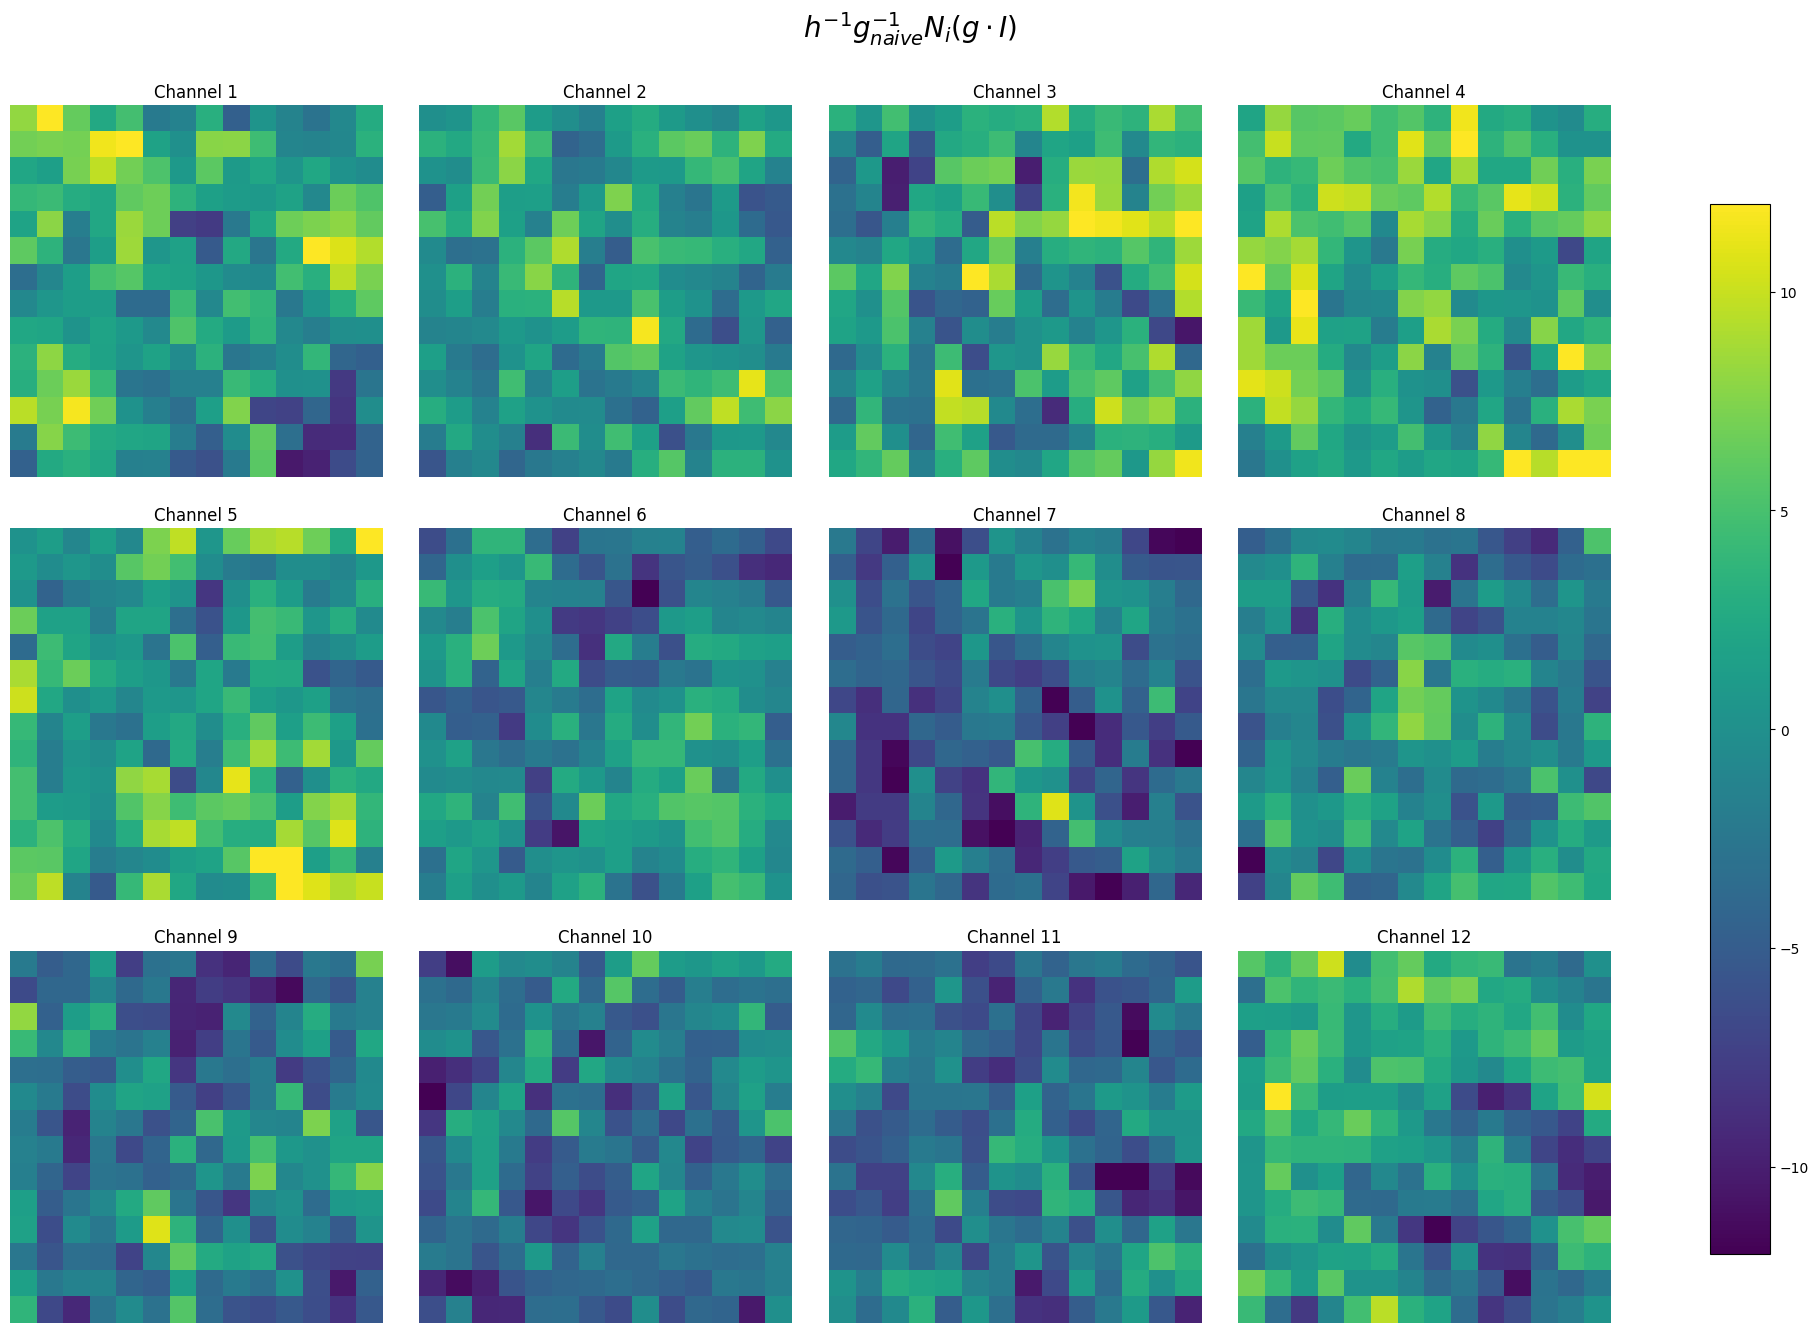

In [133]:
# Selct Image
layer_idx = layer_idx
feature = data[layer_idx, diffeo_idx, :, :, :]
label = ref_data[layer_idx, :, :, :]

approx_identity = torch.einsum('ab,axy->bxy', A, feature)

plot(approx_identity, 
     title='$h^{-1} g^{-1}_{naive} N_i(g \cdot I)$',
     vmin=-12,
     vmax=12)

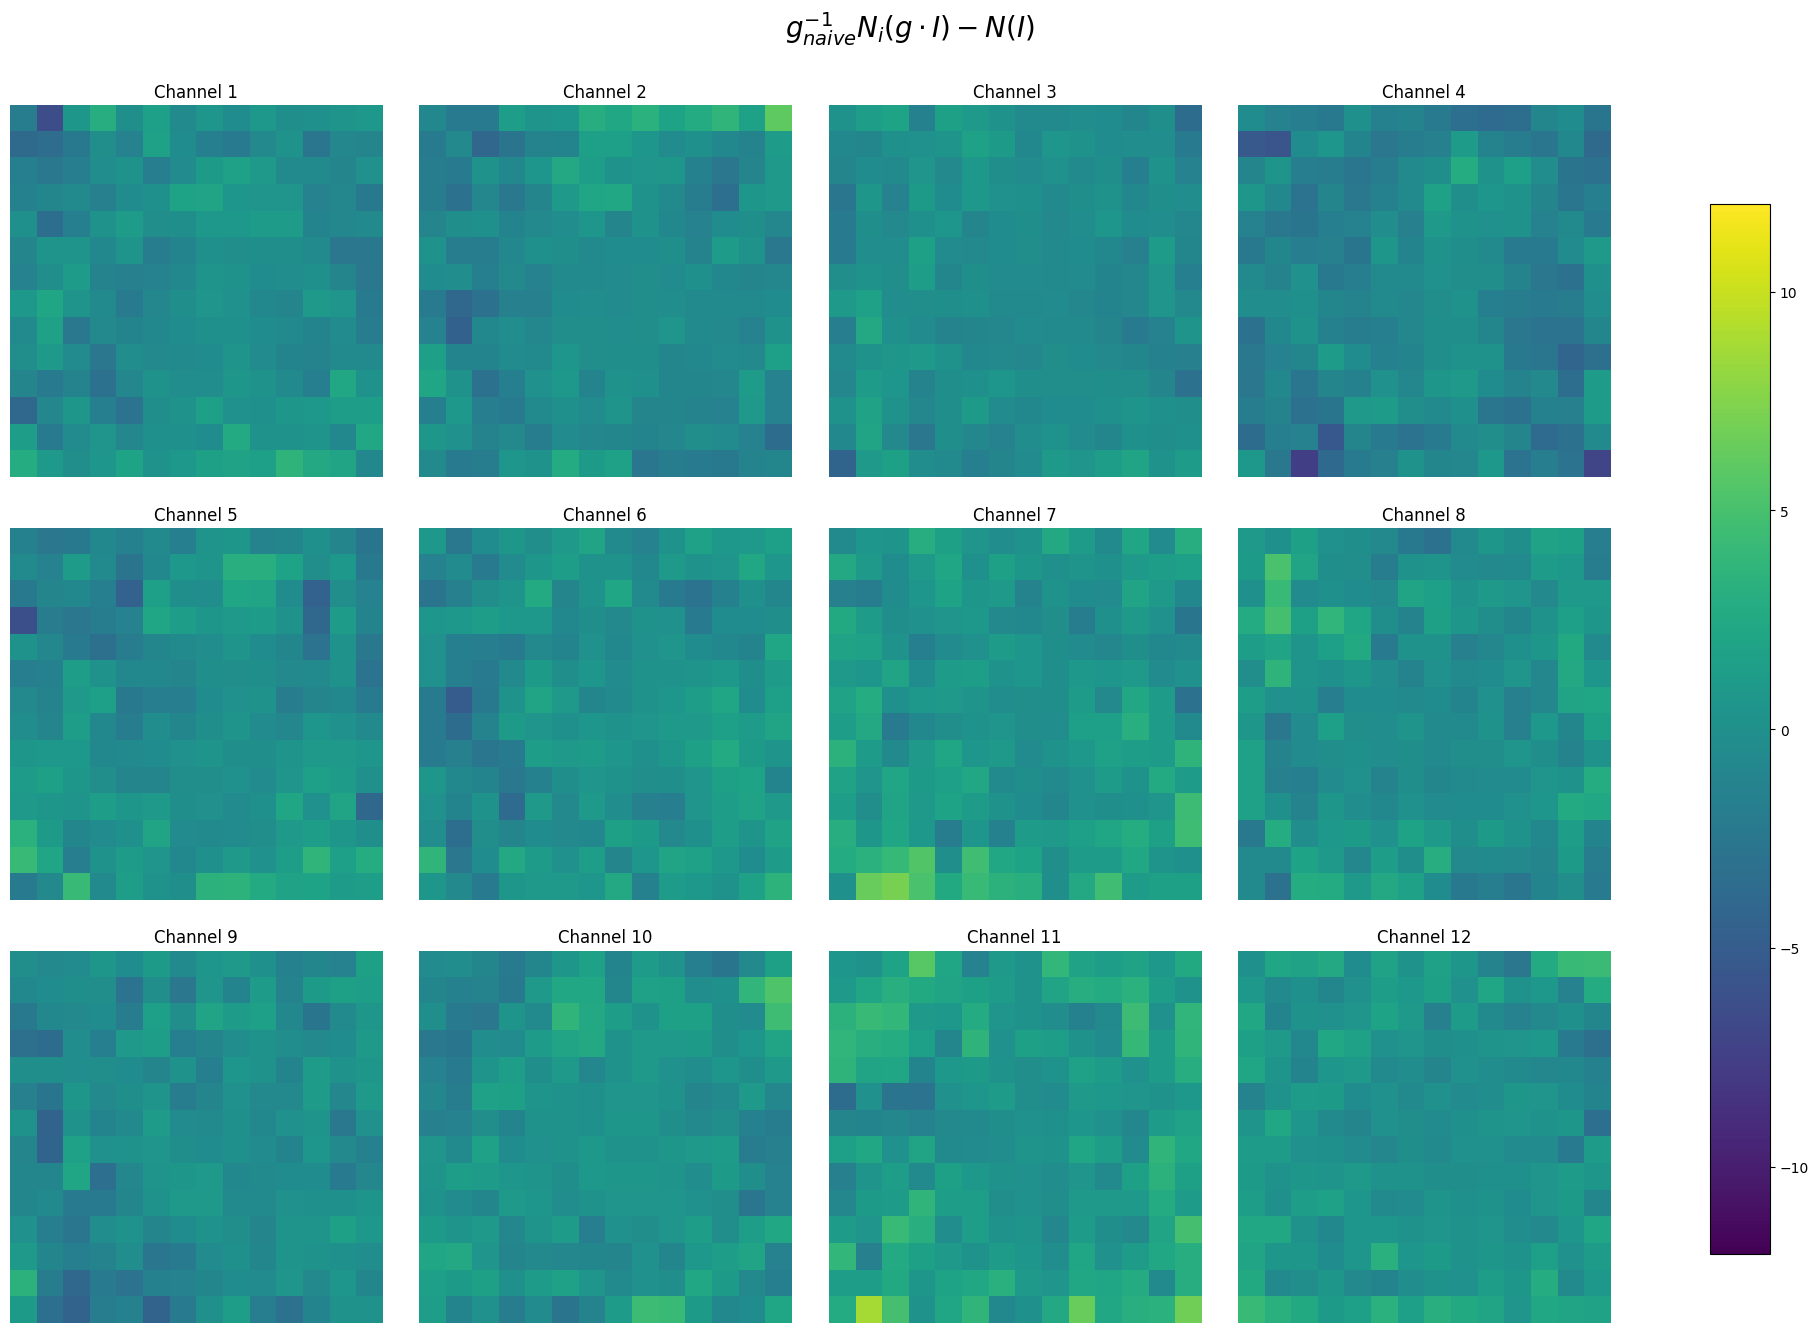

In [134]:
plot(feature - label, 
     title = '$g_{naive}^{-1} N_i(g \cdot I) - N(I)$',
     vmin=-12,
     vmax=12)

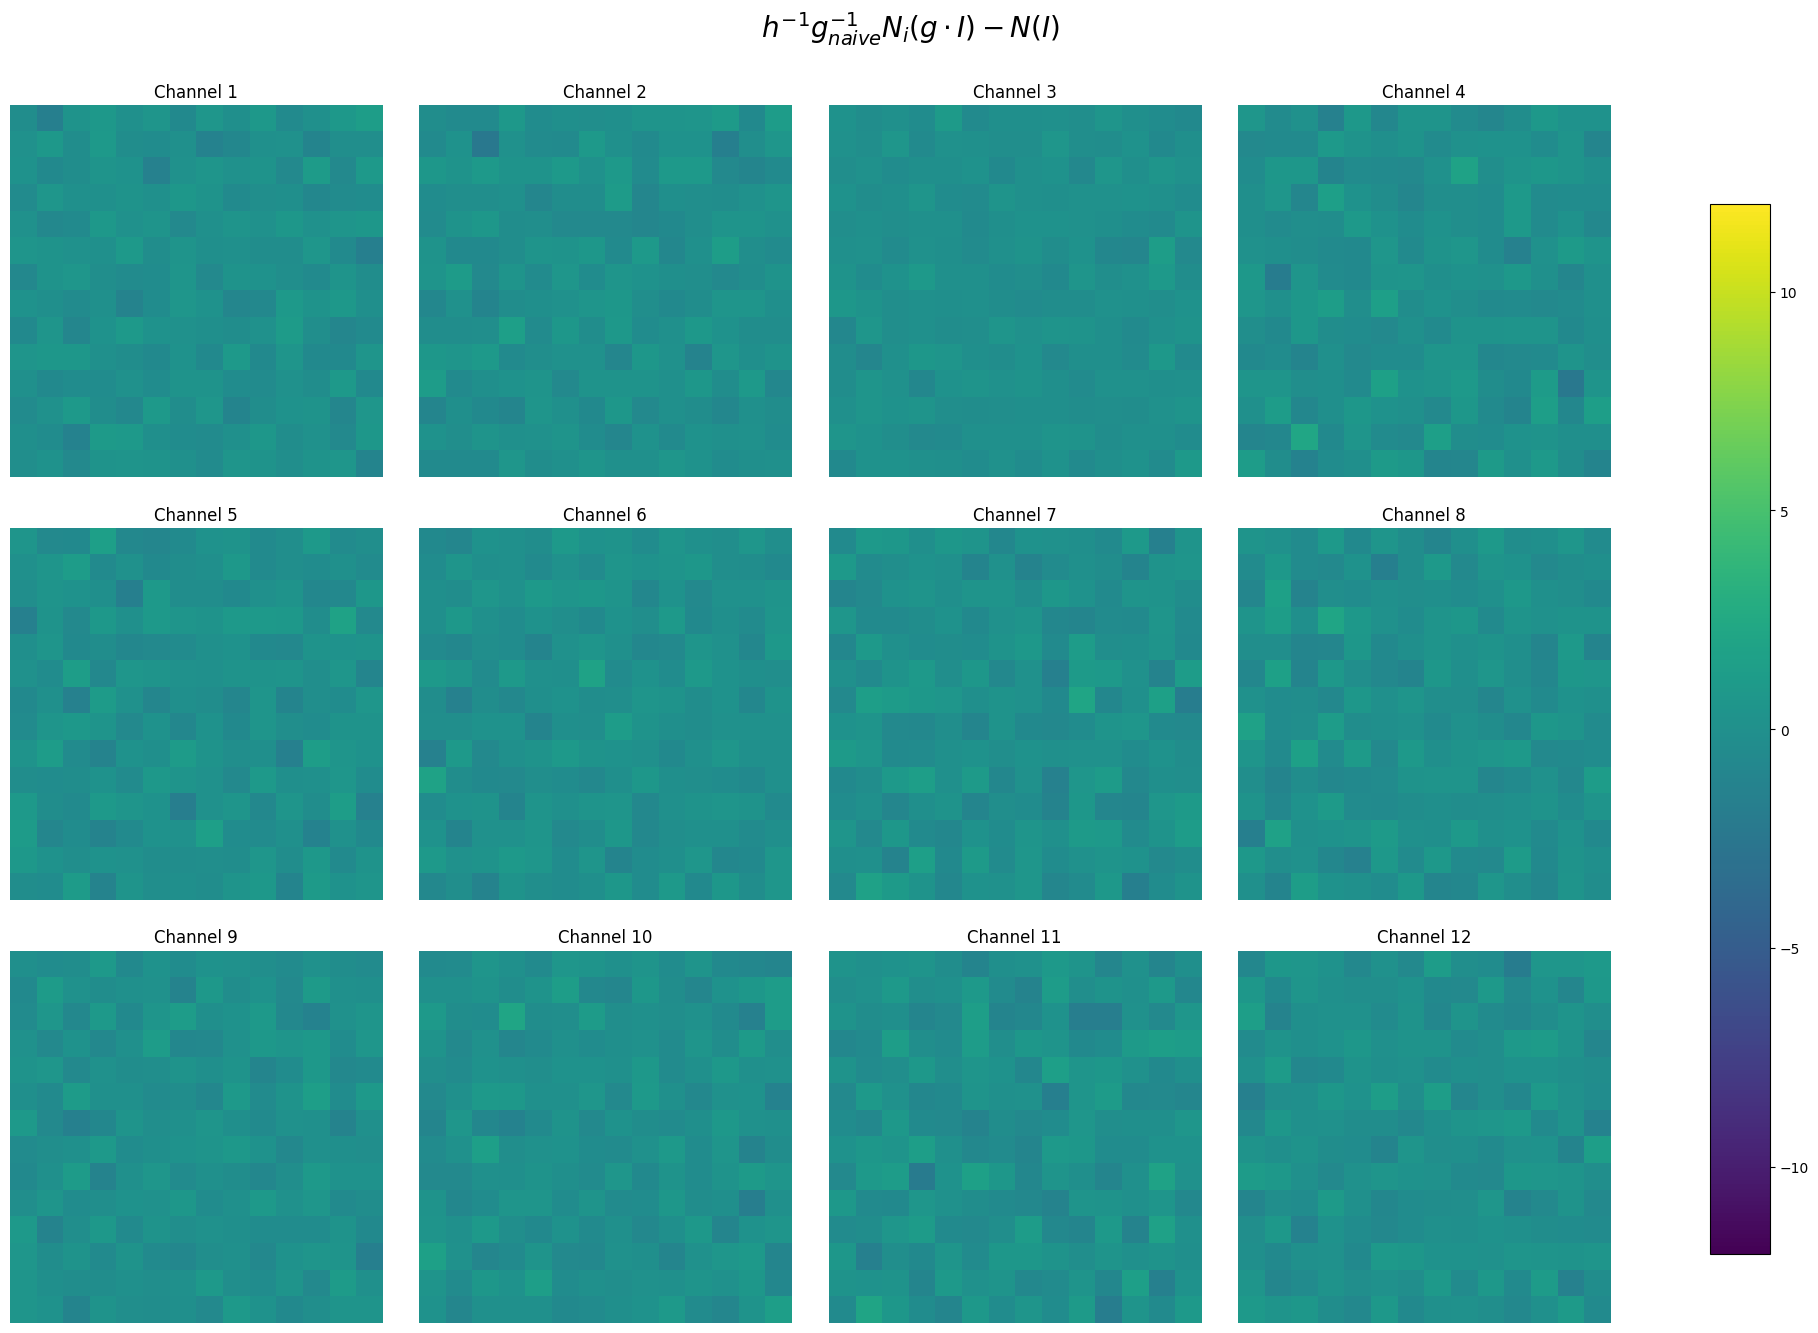

In [135]:
plot(approx_identity - label, 
     title = '$h^{-1} g_{naive}^{-1} N_i(g \cdot I) - N(I)$',
     vmin=-12,
     vmax=12)

In [136]:
error_per_pixel = lambda y_hat, y: torch.sum(torch.abs(y_hat - y)) / torch.numel(y)

print(f'For Layer {layer_idx + 14}')
print(f'Avg Error Per Pixel, NOT using h^-1: {float(error_per_pixel(feature, label)):.7f}')
print(f'Avg Error Per Pixel, using h^-1: {float(error_per_pixel(approx_identity, label)):.7f}')

For Layer 19
Avg Error Per Pixel, NOT using h^-1: 1.1177591
Avg Error Per Pixel, using h^-1: 0.5043420
